In [231]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [232]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [233]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [234]:
len(numberbatch.vocab)

651859

In [235]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [236]:
ds_techniques = pd.read_csv('datasets/silknow/es_visual_item_post2.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,"Luis XV, Rey de Francia",floral motif
1,Edad Moderna,vegetal motif
2,Edad Moderna,floral motif
3,Edad Moderna,vegetal motif
4,La decoración de estos abanicos es bastante se...,geometrical motif


In [237]:
ds_techniques.label.value_counts()

floral motif         965
vegetal motif        204
geometrical motif    125
bunch                 39
leaf                  36
thistle               35
fleur-de-lis           8
rhombus                6
vine                   4
rose                   2
Name: label, dtype: int64

In [238]:
len(ds_techniques)

1424

In [239]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [240]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [241]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [242]:
sorted(ds_techniques.label.unique())

['bunch',
 'fleur-de-lis',
 'floral motif',
 'geometrical motif',
 'leaf',
 'rhombus',
 'rose',
 'thistle',
 'vegetal motif',
 'vine']

In [243]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [244]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""


mapping = { 'vegetal motif':'planta',
            'floral motif':'flor',
            'geometrical motif':'geometría',
            'fleur-de-lis':'flor',
            'bunch':'flor',
            'vine':'planta',
            'thistle':'planta',
            'rhombus':'geometría',
            'rose':'flor',
            'leaf':'planta'           
            }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

3
['flor', 'geometría', 'planta']


In [245]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 98.4 ms, sys: 486 µs, total: 98.9 ms
Wall time: 94.4 ms


In [246]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'flor': 475, 'geometría': 164, 'planta': 1418}

In [247]:
labels_cgr.keys()

dict_keys(['flor', 'geometría', 'planta'])

In [248]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [249]:
ds_techniques.text[0]

'Luis XV, Rey de Francia'

In [250]:
data_silknow = ds_techniques.text.tolist()

In [251]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [252]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 115 ms, sys: 1.44 s, total: 1.56 s
Wall time: 1.62 s


In [253]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [254]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [255]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 49.8 ms, sys: 1.36 s, total: 1.41 s
Wall time: 1.37 s


In [256]:


predictions[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [257]:

prediction_labels = [labels[p] for p in predictions]

In [258]:
set(prediction_labels)

{'flor', 'geometría', 'planta'}

In [259]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Visual Items

In [260]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('visual-items-es-predictions.csv')

              precision    recall  f1-score   support

        flor      0.993     0.721     0.835      1397
   geometría      0.031     1.000     0.059         4
      planta      0.022     0.261     0.040        23

    accuracy                          0.714      1424
   macro avg      0.348     0.661     0.311      1424
weighted avg      0.975     0.714     0.820      1424



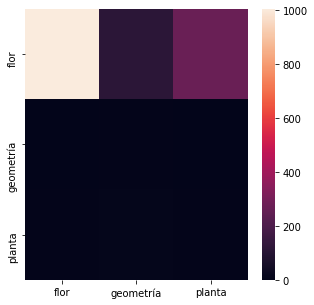

In [261]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [262]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        flor      0.003     0.429     0.006         7
   geometría      0.962     1.000     0.981       126
      planta      1.000     0.216     0.355      1291

    accuracy                          0.287      1424
   macro avg      0.655     0.548     0.447      1424
weighted avg      0.992     0.287     0.409      1424



In [263]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        flor      1.000     1.000     1.000      1014
   geometría      1.000     1.000     1.000       131
      planta      1.000     1.000     1.000       279

    accuracy                          1.000      1424
   macro avg      1.000     1.000     1.000      1424
weighted avg      1.000     1.000     1.000      1424

